In [1]:
# MO444-A 2s/2017 - Second assignment
#
#         Group 05
#
# - Anderson Rossanez (124136)
# - Bruno Branta Lopes (31470)
#

from __future__ import print_function
from scipy import misc
import glob
import numpy as np
from math import sqrt
from skimage.io import imread
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Some definitions
classes = np.asarray(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

def load_image_dataset(name, n):
    images = []
    with open('cifar-10/%s/labels' % name) as labels:
        i = 0
        for path in sorted(glob.glob('cifar-10/%s/*.png' % name)):
            # Reading the images as grayscale to have a 32x32 matrix,
            # instead of a 32x32x3 matrix in case of RGB.
            images.append((imread(path, as_grey=True), labels.next()))
            i += 1
            if i >= n:
                break
    return images

def load_dataset(name):
    dataset = load_image_dataset(name=name, n = 50000)
    
    data_X = [i[0] for i in dataset]
    data_Y = [int(i[1]) for i in dataset]
    
    return np.array(data_X), np.array(data_Y)

In [2]:
# Load train dataset
data_X, data_Y = load_dataset('train')

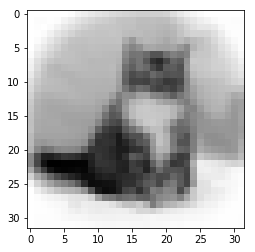

Label: 3


In [3]:
# Take a look at a sample and its class (207 should be a cat [3])
plt.imshow(data_X[207], cmap='gray')
plt.show()

print('Label: %s' % data_Y[207])

In [4]:
# Flatten data to 1-D
def flatten_data(data):
    reshaped = data.reshape(-1, 32*32)
    return reshaped

print('Previous shape: {}'.format(data_X.shape))

data_X = flatten_data(data_X)

print('Flattened shape: {}'.format(data_X.shape))

Previous shape: (50000, 32, 32)
Flattened shape: (50000, 1024)


In [5]:
# Implementing K-Fold to help avoiding overfitting
from sklearn.model_selection import KFold
from datetime import datetime

random_state = np.random.RandomState(1)

# prepare for 5-fold execution
k5_fold = KFold(n_splits=5, shuffle=True, random_state=random_state)

def run_kfold(method, data_Y, data_X, scale=False, partial_fit=False):
    train_precision, train_recall, train_f1 = [], [], []
    validation_precision, validation_recall, validation_f1 = [], [], []
    start_time = datetime.now()
    k = 0
    print('k', end=' ')
    model = None
    for train_index, validation_index in k5_fold.split(data_X):
        k += 1
        print(k, end=' ')
        
        train_data_X, train_data_Y = data_X[train_index], data_Y[train_index]
        validation_data_X, validation_data_Y = data_X[validation_index], data_Y[validation_index]
        
        if scale:
            model_scaler = preprocessing.StandardScaler()
            train_data_X = model_scaler.fit_transform(train_data_X)
            validation_data_X = model_scaler.transform(validation_data_X)
        
        if partial_fit:
            # feed the data partially
            n_chunks = 10
            chunk_size = len(train_data_Y) / n_chunks
            for i in range(0, n_chunks):
                range_start = i * chunk_size
                range_end = (i + 1) * chunk_size
                model = method(train_data_X[range_start:range_end], train_data_Y[range_start:range_end]) 
        else:
            model = method(train_data_X, train_data_Y)
        
        predicted_train_data_Y = model.predict(train_data_X)
        train_precision.append(precision_score(train_data_Y, predicted_train_data_Y))
        train_recall.append(recall_score(train_data_Y, predicted_train_data_Y))
        train_f1.append(f1_score(train_data_Y, predicted_train_data_Y))
        
        predicted_validation_data_Y = model.predict(validation_data_X)
        validation_precision.append(precision_score(validation_data_Y, predicted_validation_data_Y))
        validation_recall.append(recall_score(validation_data_Y, predicted_validation_data_Y))
        validation_f1.append(f1_score(validation_data_Y, predicted_validation_data_Y))
    print('time elapsed: {}\n'.format(datetime.now() - start_time))
    print('             Precision  Recall  F1 Score')
    print('Training:      %5.2f    %5.2f   %5.2f' % (np.mean(train_precision), np.mean(train_recall), np.mean(train_f1)))
    print('Validation:    %5.2f    %5.2f   %5.2f' % (np.mean(validation_precision), np.mean(validation_recall), np.mean(validation_f1)))
    return model

In [6]:
# Create a baseline One-vs-All logistic regression model

def one_vs_all(data_X, data_Y, num_classes):
    classifiers = []
    for i in range(num_classes):
        # 1 for this class, 0 for all the others
        data_Y_i = np.array([1 if j == i else 0 for j in data_Y])
        
        print('Logistic Regression (OVA) model %d/%d' % (i+1, num_classes))
        
        # train and run using k-fold to help avoid overfitting 
        this_model = run_kfold(lambda X, Y: SGDClassifier(loss='log', random_state=random_state).fit(X, Y), data_Y_i, data_X)
        classifiers.append(this_model)
    
    return classifiers

# Train, run, and measure
one_vs_all(data_X, data_Y, len(classes))


Logistic Regression (OVA) model 1/10
k 1 2 

/Library/Python/2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Python/2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


3 4 5 time elapsed: 0:00:04.404142

             Precision  Recall  F1 Score
Training:       0.25      0.11    0.09
Validation:     0.21      0.09    0.08
Logistic Regression (OVA) model 2/10
k 1 2 3 4 5 time elapsed: 0:00:04.528377

             Precision  Recall  F1 Score
Training:       0.50      0.22    0.29
Validation:     0.44      0.20    0.26
Logistic Regression (OVA) model 3/10
k 1 2 3 4 5 time elapsed: 0:00:04.243258

             Precision  Recall  F1 Score
Training:       0.20      0.13    0.09
Validation:     0.11      0.12    0.09
Logistic Regression (OVA) model 4/10
k 1 2 3 4 5 time elapsed: 0:00:04.237693

             Precision  Recall  F1 Score
Training:       0.32      0.07    0.08
Validation:     0.27      0.06    0.07
Logistic Regression (OVA) model 5/10
k 1 2 3 4 5 time elapsed: 0:00:04.575314

             Precision  Recall  F1 Score
Training:       0.24      0.10    0.06
Validation:     0.25      0.10    0.06
Logistic Regression (OVA) model 6/10
k 1 2 3 4 5 time

[SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
        eta0=0.0, fit_intercept=True, l1_ratio=0.15,
        learning_rate='optimal', loss='log', n_iter=5, n_jobs=1,
        penalty='l2', power_t=0.5,
        random_state=<mtrand.RandomState object at 0x1149d8be0>,
        shuffle=True, verbose=0, warm_start=False),
 SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
        eta0=0.0, fit_intercept=True, l1_ratio=0.15,
        learning_rate='optimal', loss='log', n_iter=5, n_jobs=1,
        penalty='l2', power_t=0.5,
        random_state=<mtrand.RandomState object at 0x1149d8be0>,
        shuffle=True, verbose=0, warm_start=False),
 SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
        eta0=0.0, fit_intercept=True, l1_ratio=0.15,
        learning_rate='optimal', loss='log', n_iter=5, n_jobs=1,
        penalty='l2', power_t=0.5,
        random_state=<mtrand.RandomState object at 0x1149d8be0>,
        shuffl